In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import time, datetime
import scipy
import lightgbm

#띄어쓰기
from pycrfsuite_spacing import TemplateGenerator
from pycrfsuite_spacing import CharacterFeatureTransformer
from pycrfsuite_spacing import PyCRFSuiteSpacing
from soyspacing.countbase import CountSpace

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # 다항분포 나이브 베이즈 모델
from sklearn.metrics import accuracy_score #정확도 계산
from scipy.sparse import hstack

# 데이터 체크

In [2]:
train = pd.read_csv("C:/cook/dacon/public_test.csv") ## test

In [3]:
train.columns

Index(['id', 'year_month', 'text'], dtype='object')

In [4]:
train.index

RangeIndex(start=0, stop=1626, step=1)

In [5]:
train.head()

,id,year_month,text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...


# 분석 시작

In [6]:
print(train['year_month'].min(), train['year_month'].max())

2019-01 2019-04


(array([299.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 332.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 459.,   0.,   0.,   0.,   0.,   0.,
          0., 536.]),
 array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
        1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
        2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   ]),
 <a list of 24 Patch objects>)

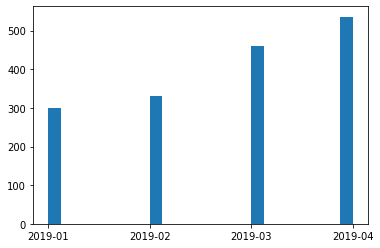

In [7]:
plt.hist(train['year_month'], bins=24)

In [8]:
date = []
p = re.compile('2017-')
q = re.compile('2018-')
for i in train['year_month']:
    if p.match(i):
        date.append(int(i.replace("2017-", "")))
    elif q.match(i):
        date.append(int(i.replace("2018-", "")) + 12)
    else:
        date.append(int(i.replace("2019-", "")) + 24)

In [9]:
season = list(range(0,len(date)))
for i in range(0,len(date)):
    season[i] = math.ceil(date[i] / 3)
train["season"] = season

# 텍스트 길이 분석

In [10]:
length_x = [] # 스미싱 문자

for i in train['text']:
    length_x.append(len(i))    

In [11]:
length_x = pd.DataFrame(length_x)
length_x.describe()

,0
count,1626.000000
mean,320.535670
std,251.631687
min,4.000000
25%,130.250000
50%,230.500000
75%,443.750000
max,1155.000000


In [12]:
length_text= []
for i in train.values:
    length_text.append([i[0],len(i[2])])
length_text = pd.DataFrame(length_text)

In [13]:
length_text.rename(columns={0:"id", 1:"length_text"}, inplace =True)
length_text

,id,length_text
0,340000,500
1,340001,618
2,340002,129
3,340003,90
4,340004,282
...,...,...
1621,341621,293
1622,341622,86
1623,341623,88
1624,341624,685


In [14]:
train = pd.merge(train, length_text, how = 'inner')
train

,id,year_month,text,season,length_text
0,340000,2019-01,XXX고객님! 안녕하세요? 새롭게 시작하는 한 주 행복 가득하시길 기원합니다. 지난...,9,500
1,340001,2019-01,긴급 안내 XXX은행 가락동 지점 - 헬리오XXX 기본XXX 대출이자를 ...,9,618
2,340002,2019-01,XXX 고객님 안녕하세요올해는 미세먼지가 유난인거 같습니다.엊그제 새해가 시작된거같...,9,129
3,340003,2019-01,XXX 고객님찾아온 행운을 잡으셨나요? 못잡으셨다면 이번에 다시 잡으시길 기원합니다...,9,90
4,340004,2019-01,XXX 고객님새해 복 많이 받으세요 XXX은행 코스트코 퇴직연금 담당자입니다. 고...,9,282
...,...,...,...,...,...
1621,341621,2019-04,(광고)XXX 고객님안녕하십니까!!고객님의 소중한 업무처리를 도와드린 kb창원중앙동...,10,293
1622,341622,2019-04,고객님 항상 저희 지점을 거래해 주셔서 감사합니다 본점 서비스 설문 전화 받으시면...,10,86
1623,341623,2019-04,XXX 고객님 저희 XXX은행 XXX지점을 이용해주셔서 감사드립니다 이번주도 더 ...,10,88
1624,341624,2019-04,(광고)알림 신청하면 매일 현금 100만원! XXX부동산 리브온지금 XXX부동산 리...,10,685


# 띄어쓰기와 형태소 분석

# crf spacing

# soy spacing

In [15]:
train['clean_doc'] = train['text']

# 삭제용
time = ['\d+년[가-힣]{0,1}',
        '\d+월[가-힣]{0,1}',
        '\d+일[가-힣]{0,1}',
        '[(]월[)]',
        '[(]화[)]',
        '[(]수[)]',
        '[(]목[)]',
        '[(]금[)]',
        '[(]토[)]',
        '[(]일[)]']

money = ["\d+억{0,1}만{0,1}원", "\d*일*\d*십*\d*백*\d*천*\d*만*\d*억*\d*원"]


# 변수 추가용
anboo = ['감사','행복', '사랑', '즐거', '고맙']
myeonjeol = ['새해', '추석', '설날', '구정', '신정', '한가위', '명절', '연휴']
sorry = ['파업', '불편', '양해', '사과', '죄송', '이해', '이전', '이동', '발령']
callme = ['문자', '연락', '전화', '답장', '상담']
visit = ['내점', '방문']
daechool = ['대출', '대환', '증액', '채무', '연체', '원리금', '부채', '상환', '']
event = ["이벤트", "당첨", "추첨", "응모"]
interest = ['\d[.]\d+\%']
link = ['http']
kakao = ['톡\s*상담', 'KISA', 'ID\s*:']

def make_col(target, colname_str):
    colname = colname_str
    train[colname] = 0
    
    for t in target:
        count = -1
        p = re.compile(t)
        
        for i in train['clean_doc']:
            count += 1
            
            if p.findall(i):
                train[colname][count] += 1

def del_text(target):
    train['clean_doc'] = train['clean_doc'].str.replace(target," ")

In [16]:
make_col(anboo, "anboo")
make_col(myeonjeol, "myeongjeol")
make_col(sorry, "sorry")
make_col(callme, "callme")
make_col(visit, "visit")
make_col(daechool, "daechool")
make_col(event, "event")
make_col(interest, "interest")
make_col(link, "link")
make_col(kakao, "kakao")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [17]:
train['clean_doc'] = train['text']

for m in money:
    del_text(m)

for i in time:
    del_text(i)

train['clean_doc'] = train['clean_doc'].str.replace("[^가-힣+]"," ")

In [18]:
begin_time = datetime.datetime.now()
print(begin_time)
to_feature = CharacterFeatureTransformer(
    TemplateGenerator()
    )

model_path = 'demo_model.crfsuite'
correct = PyCRFSuiteSpacing(to_feature)
correct.load_tagger(model_path)
end_time = datetime.datetime.now()
print(end_time - begin_time)

2020-01-06 13:41:58.132530
0:00:04.388987


In [19]:
begin_time = datetime.datetime.now()
clean_doc2 = []
for i in train['clean_doc']:
    clean_doc2.append(correct(i))

end_time = datetime.datetime.now()
print(end_time- begin_time)

0:00:04.977200


In [20]:
train['clean_doc'] = clean_doc2

# 주제 찾기 시작

In [21]:
import eunjeon
tagger = eunjeon.Mecab()

In [22]:
result = []
for i in train['clean_doc']:
    result.append(tagger.nouns(i))

In [23]:
detokenized_doc = []
for i in range(len(result)):
    t = ' '.join(result[i])
    detokenized_doc.append(t)

detokenized_doc[0]

'고객 안녕 시작 주 행복 지난주 글로벌 증시 파월 미 연준 의장 통화 정책 완화 태도 변화 것 주초 투자 심리 개선 폭 상승 마감 미 중 차관 급 무역 협상 순조 진행 점 긍정 달러 환율 주간 하락 가운데 외국인 투자자 국내 증시 매수 규모 천억 상회 수급 개선 점 주목 필요 금주 시장 미국 금융 주 실적 발표 시작 본격 실적 시즌 진입 지난주 애플 삼성전자 등 주요 기업 분기 실적 전망 하향 조정 점 참고 올해 글로벌 성장 둔화 기조 속 기업 순익 감소 추이 관심 필요 후반 브렉 시트 영국 표결 예정 날씨 건강 유의 한주 감사 은행 송도 센터'

In [24]:
train['detoken'] = detokenized_doc

In [25]:
train.isna().sum()

id             0
year_month     0
text           0
season         0
length_text    0
clean_doc      0
anboo          0
myeongjeol     0
sorry          0
callme         0
visit          0
daechool       0
event          0
interest       0
link           0
kakao          0
detoken        0
dtype: int64

In [28]:
train['detoken'].fillna(" ", inplace = True)
train_set = train.drop(['year_month','text', 'clean_doc'], axis=1)
train_set.to_csv("test_detoken.csv", index = False)